### Kaggle Competition | Titanic Machine Learning from Disaster

>The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew.  This sensational tragedy shocked the international community and led to better safety regulations for ships.

>One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.  Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

>In this contest, we ask you to complete the analysis of what sorts of people were likely to survive.  In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

>This Kaggle Getting Started Competition provides an ideal starting place for people who may not have a lot of experience in data science and machine learning.

From the competition [homepage](http://www.kaggle.com/c/titanic-gettingStarted).


### Goal for this Notebook:
Show a simple example of an analysis of the Titanic disaster in Python using a full complement of PyData utilities. This is aimed for those looking to get into the field or those who are already in the field and looking to see an example of an analysis done with Python.

#### This Notebook will show basic examples of: 
#### Data Handling
*   Importing Data with Pandas
*   Cleaning Data
*   Exploring Data through Visualizations with Matplotlib

#### Data Analysis
*    Supervised Machine learning Techniques:
    +   Logit Regression Model 
    +   Plotting results
    +   Support Vector Machine (SVM) using 3 kernels
    +   Basic Random Forest
    +   Plotting results

#### Valuation of the Analysis
*   Using different measures auch as precision, recall, accuracy, F1
* Introducing ROC tables
*   K-folds cross validation to evaluate results locally


In [1]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn import preprocessing, model_selection, linear_model, svm, ensemble
from sklearn.metrics import roc_curve, auc
#import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

### Data Handling
#### Let's read our data in using pandas:

In [4]:
df = pd.read_csv("../dataset/titanic.csv") 

Show an overview of our data: 

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Let's take a look:

Above is a summary of our data contained in a `Pandas` `DataFrame`. Think of a `DataFrame` as a Python's super charged version of the workflow in an Excel table. As you can see the summary holds quite a bit of information. First, let us check the number of observations (passengers) and features.

In [6]:
df.shape

(891, 12)

The first number is the number of rows (observations), while the second one is the number of columns (features). 

Next, let us also list the set of features.

In [7]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

These are the meanings of each feature:

*Survival*: Survival(0 = No; 1 = Yes)  
*Pclass*: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)  
*Name*: Name  
*Sex*: Sex (female, male)  
*Age*: Age  
*SibSp*: Number of Siblings/Spouses Aboard  
*Parch*: Number of Parents/Children Aboard  
*Ticket*: Ticket Number  
*Fare*: Passenger Fare  
*Cabin*: Cabin  
*Embarked*: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

Let us also check how many values each column contains

In [8]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

While most of our features have complete data on every observation, like the *Survived* feature, some are missing information, like the *Age*, *Cabin*, and *Embarked* ones.  These missing values are represented as `NaN`s.

### Take care of missing values:
The features *Age* and *Cabin* have many missing values, while *Embarked* just a few. Since *Cabin* do not seem to add much value to our analysis, we will drop it from the dataframe.

In [9]:
df = df.drop(['Cabin'], axis=1) 
df.shape

(891, 11)

Next, we also drop any observation (row in the dataframe) containing missing values in any column.

In [10]:
df = df.dropna() 
df.shape

(712, 11)

In [11]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### Let's take a look at our data graphically:

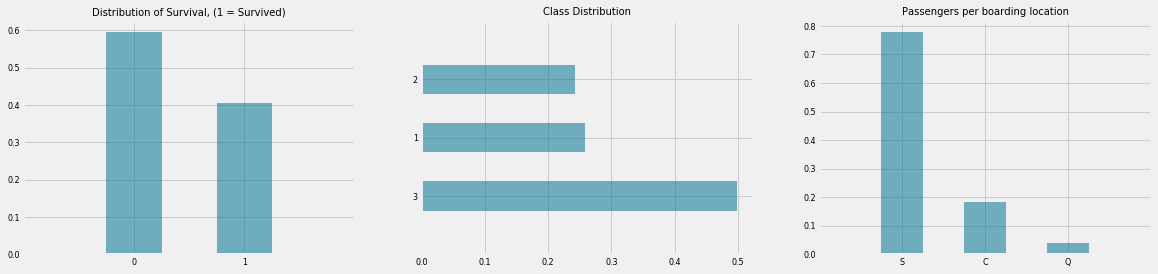

In [13]:
fig = plt.figure(figsize=(18,4)) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

ax1 = plt.subplot2grid((1,3),(0,0))               
(df.Survived.value_counts()/df.shape[0]).plot(kind='bar', alpha=alpha_bar_chart, color=colors[1])
ax1.set_xlim(-1, 2)
plt.setp(plt.xticks()[1], rotation=0)
plt.title("Distribution of Survival, (1 = Survived)")    

ax3 = plt.subplot2grid((1,3),(0,1))
(df.Pclass.value_counts()/df.shape[0]).plot(kind="barh", alpha=alpha_bar_chart, color=colors[1])
ax3.set_ylim(-1, len(df.Pclass.value_counts()))
plt.title("Class Distribution")


ax5 = plt.subplot2grid((1,3),(0,2))
(df.Embarked.value_counts()/df.shape[0]).plot(kind='bar', alpha=alpha_bar_chart, color=colors[1])
ax5.set_xlim(-1, len(df.Embarked.value_counts()))
plt.setp(plt.xticks()[1], rotation=0)
plt.title("Passengers per boarding location")
plt.show()

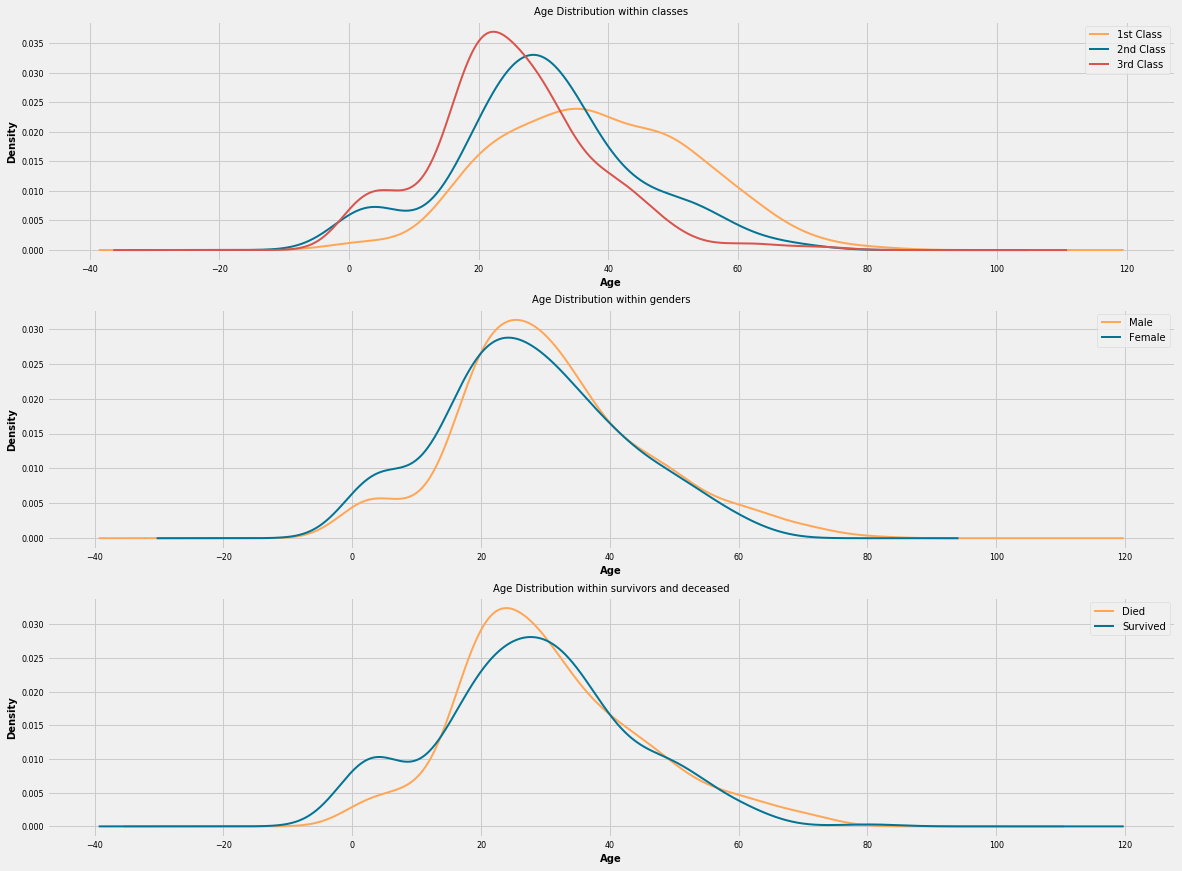

In [88]:
fig = plt.figure(figsize=(18,14)) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

plt.subplot2grid((3,1),(0,0))
df.Age[df.Pclass == 1].plot(kind='kde', color=colors[0])    
df.Age[df.Pclass == 2].plot(kind='kde', color=colors[1])
df.Age[df.Pclass == 3].plot(kind='kde', color=colors[2])
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 


plt.subplot2grid((3,1),(1,0))
df.Age[df.Sex == 'male'].plot(kind='kde', color=colors[0])    
df.Age[df.Sex == 'female'].plot(kind='kde', color=colors[1])
plt.xlabel("Age")    
plt.title("Age Distribution within genders")
plt.legend(('Male', 'Female'),loc='best')

plt.subplot2grid((3,1),(2,0))
df.Age[df.Survived == 0].plot(kind='kde', color=colors[0])    
df.Age[df.Survived == 1].plot(kind='kde', color=colors[1])
plt.xlabel("Age")    
plt.title("Age Distribution within survivors and deceased")
l=plt.legend(('Died', 'Survived'),loc='best')


### Exploratory Visualization:

We wish to predict if an individual will survive based on the features in the data like:
 
 * Traveling Class (called pclass in the data)
 * Sex 
 * Age
 * Fare Price

Let’s see if we can gain a better understanding of who survived and died. 


First let’s plot a bar graph of those who Survived Vs. Those who did not.


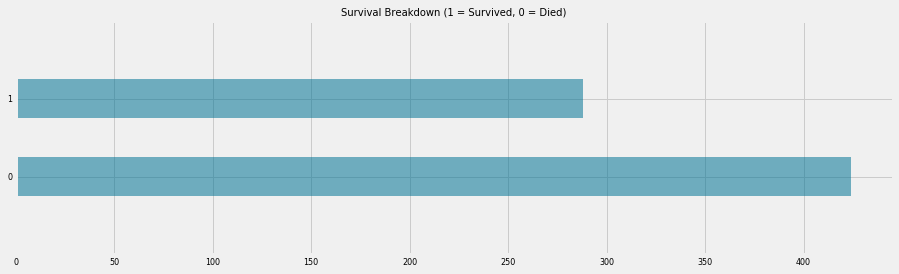

In [85]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1, 1, 1)
df.Survived.value_counts().plot(kind='barh', color=colors[1], alpha=alpha_bar_chart)
ax.set_ylim(-1, len(df.Survived.value_counts())) 
t=plt.title("Survival Breakdown (1 = Survived, 0 = Died)")

### Now let’s tease more structure out of the data,
### Let’s break the previous graph down by gender


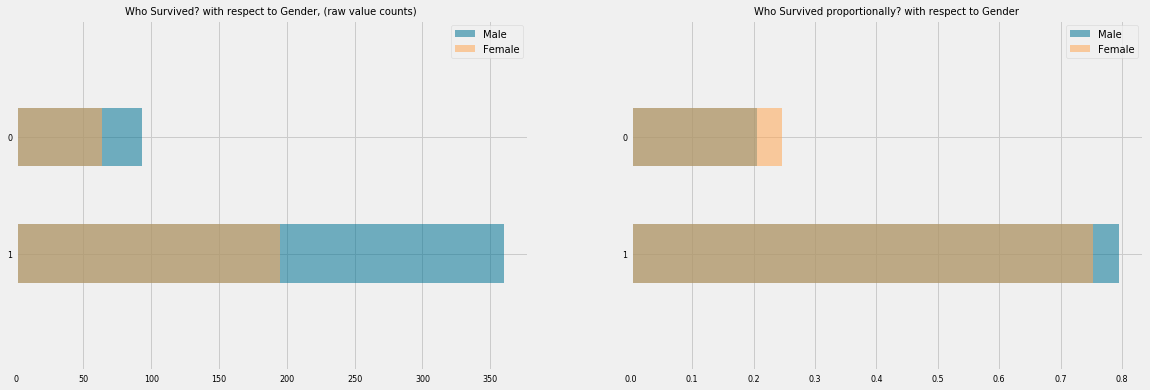

In [93]:
fig = plt.figure(figsize=(18,6))

# create a plot of two subsets, male and female, of the survived variable.
# After we do that we call value_counts() so it can be easily plotted as a bar graph. 
# 'barh' is just a horizontal bar graph
ax1 = fig.add_subplot(121)
df.Survived[df.Sex == 'male'].value_counts().plot(kind='barh',color=colors[1], alpha=alpha_bar_chart, label='Male')
df.Survived[df.Sex == 'female'].value_counts().plot(kind='barh', color=colors[0], alpha=alpha_bar_chart,label='Female')
ax1.set_ylim(-1, 2) 
plt.title("Who Survived? with respect to Gender, (raw value counts) ") 
l=plt.legend(loc='best')


# adjust graph to display the proportions of survival by gender
ax2 = fig.add_subplot(122)
(df.Survived[df.Sex == 'male'].value_counts()/float(df.Sex[df.Sex == 'male'].size)).plot(kind='barh',color=colors[1], alpha=alpha_bar_chart,label='Male')  
(df.Survived[df.Sex == 'female'].value_counts()/float(df.Sex[df.Sex == 'female'].size)).plot(kind='barh', color=colors[0], alpha=alpha_bar_chart,label='Female')
ax2.set_ylim(-1, 2)
plt.title("Who Survived proportionally? with respect to Gender") 
l=plt.legend(loc='best')

Here it’s clear that although more men died and survived in raw value counts, females had a greater survival rate proportionally(~25%), than men (~20%)

#### Great! But let’s go down even further:
Can we capture more of the structure by using Pclass? Here we will bucket classes as lowest class or any of the high classes (classes 1 - 2). 3 is lowest class. Let’s break it down by Gender and what Class they were traveling in.


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


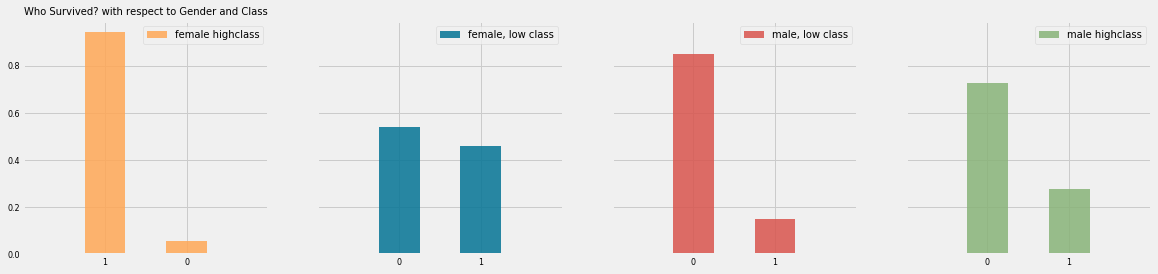

In [39]:
fig = plt.figure(figsize=(18,4))
alpha_level = 0.85

ax1=fig.add_subplot(141)
female_highclass = df.Survived[df.Sex == 'female'][df.Pclass != 3].value_counts()/float(df[df.Sex=='female'][df.Pclass != 3].shape[0])
female_highclass.plot(kind='bar', label='female highclass', color=colors[0], alpha=alpha_level)
plt.setp(plt.xticks()[1], rotation=0)
ax1.set_xlim(-1, len(female_highclass))
plt.title("Who Survived? with respect to Gender and Class"); plt.legend(loc='best')

ax2=fig.add_subplot(142, sharey=ax1)
female_lowclass = df.Survived[df.Sex == 'female'][df.Pclass == 3].value_counts()/float(df[df.Sex=='female'][df.Pclass == 3].shape[0])
female_lowclass.plot(kind='bar', label='female, low class', color=colors[1], alpha=alpha_level)
plt.setp(plt.xticks()[1], rotation=0)
ax2.set_xlim(-1, len(female_lowclass))
plt.legend(loc='best')

ax3=fig.add_subplot(143, sharey=ax1)
male_lowclass = df.Survived[df.Sex == 'male'][df.Pclass == 3].value_counts()/float(df[df.Sex=='male'][df.Pclass == 3].shape[0])
male_lowclass.plot(kind='bar', label='male, low class', color=colors[2], alpha=alpha_level)
plt.setp(plt.xticks()[1], rotation=0)
ax3.set_xlim(-1, len(male_lowclass))
plt.legend(loc='best')

ax4=fig.add_subplot(144, sharey=ax1)
male_highclass = df.Survived[df.Sex == 'male'][df.Pclass != 3].value_counts()/float(df[df.Sex=='male'][df.Pclass != 3].shape[0])
male_highclass.plot(kind='bar', label='male highclass', alpha=alpha_level, color=colors[3])
plt.setp(plt.xticks()[1], rotation=0)
ax4.set_xlim(-1, len(male_highclass))
l=plt.legend(loc='best')

Awesome! Now we have a lot more information on who survived and died in the tragedy. With this deeper understanding, we are better equipped to create better more insightful models. This is a typical process in interactive data analysis. First you start small and understand the most basic relationships and slowly increment the complexity of your analysis as you discover more and more about the data you’re working with. Below is the progression of process laid out together:

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


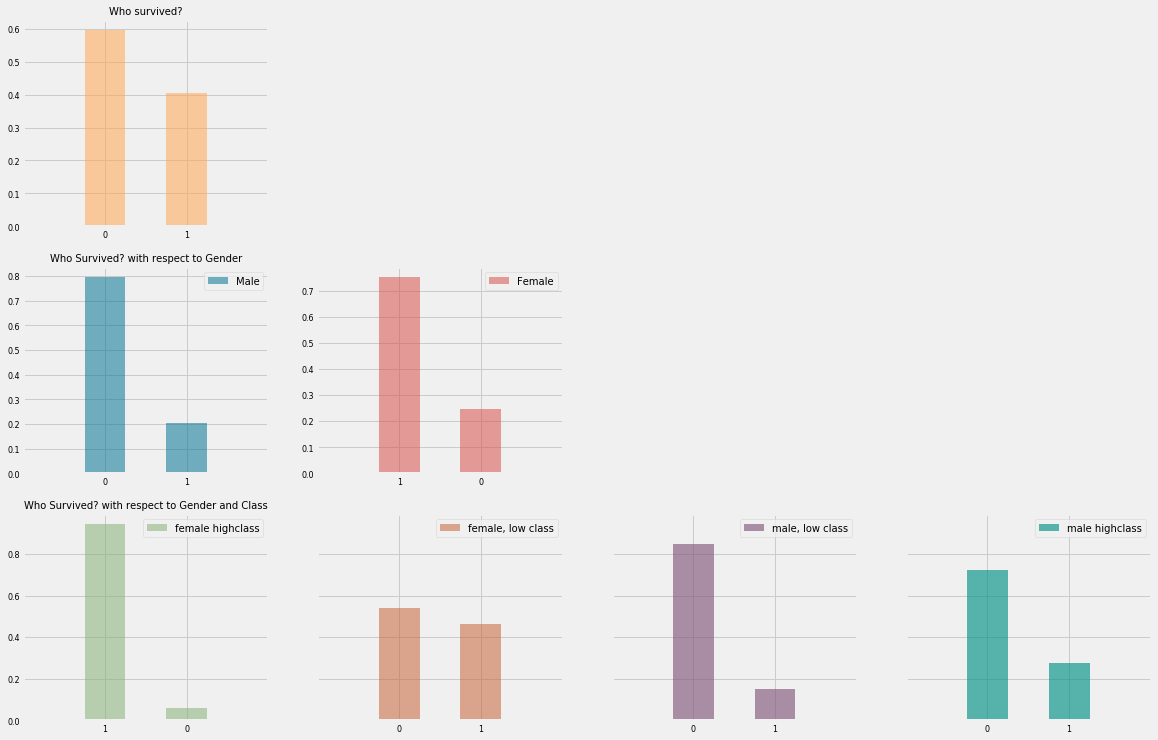

In [40]:
fig = plt.figure(figsize=(18,12))
a = 0.65
# Step 1
ax1 = fig.add_subplot(341)
(df.Survived.value_counts()/df.shape[0]).plot(kind='bar', color=colors[0], alpha=alpha_bar_chart)
plt.setp(plt.xticks()[1], rotation=0)
ax1.set_xlim(-1, len(df.Survived.value_counts()))
plt.title("Who survived?")

# Step 2
ax2 = fig.add_subplot(345)
(df.Survived[df.Sex == 'male'].value_counts()/float(df.Sex[df.Sex == 'male'].shape[0])).plot(kind='bar', color=colors[1],alpha=alpha_bar_chart,label='Male')
ax2.set_xlim(-1, 2)
plt.setp(plt.xticks()[1], rotation=0)
plt.title("Who Survived? with respect to Gender"); plt.legend(loc='best')

ax3 = fig.add_subplot(346)
(df.Survived[df.Sex == 'female'].value_counts()/float(df.Sex[df.Sex == 'female'].shape[0])).plot(kind='bar', alpha=alpha_bar_chart, color=colors[2],label='Female')
ax3.set_xlim(-1,2)
plt.setp(plt.xticks()[1], rotation=0)
plt.legend(loc='best')


# Step 3
ax4 = fig.add_subplot(349)
female_highclass = (df.Survived[df.Sex == 'female'][df.Pclass != 3].value_counts()/float(df[df.Sex == 'female'][df.Pclass != 3].shape[0]))
female_highclass.plot(kind='bar', label='female highclass', color=colors[3], alpha=alpha_bar_chart)
plt.setp(plt.xticks()[1], rotation=0)
ax4.set_xlim(-1, len(female_highclass))
plt.title("Who Survived? with respect to Gender and Class"); plt.legend(loc='best')

ax5 = fig.add_subplot(3,4,10, sharey=ax4)
female_lowclass = (df.Survived[df.Sex == 'female'][df.Pclass == 3].value_counts()/float(df[df.Sex == 'female'][df.Pclass == 3].shape[0]))
female_lowclass.plot(kind='bar', label='female, low class', color=colors[4], alpha=alpha_bar_chart)
plt.setp(plt.xticks()[1], rotation=0)
ax5.set_xlim(-1, len(female_lowclass))
plt.legend(loc='best')

ax6 = fig.add_subplot(3,4,11, sharey=ax4)
male_lowclass = (df.Survived[df.Sex == 'male'][df.Pclass == 3].value_counts()/float(df[df.Sex == 'male'][df.Pclass == 3].shape[0]))
male_lowclass.plot(kind='bar', label='male, low class',color=colors[5], alpha=a)
plt.setp(plt.xticks()[1], rotation=0)
ax6.set_xlim(-1, len(male_lowclass))
plt.legend(loc='best')

ax7 = fig.add_subplot(3,4,12, sharey=ax4)
male_highclass = (df.Survived[df.Sex == 'male'][df.Pclass != 3].value_counts()/float(df[df.Sex == 'male'][df.Pclass != 3].shape[0]))
male_highclass.plot(kind='bar', label='male highclass', alpha=a, color=colors[6])
plt.setp(plt.xticks()[1], rotation=0)
ax7.set_xlim(-1, len(male_highclass))
plt.legend(loc='best')

I've done my best to make the plotting code readable and intuitive, but if you’re looking for a more detailed look on how to start plotting in matplotlib, check out this beautiful notebook [here](http://nbviewer.ipython.org/urls/raw.github.com/jrjohansson/scientific-python-lectures/master/Lecture-4-Matplotlib.ipynb). 

Now that we have a basic understanding of what we are trying to predict, let’s predict it.
## Supervised Machine Learning
#### Logistic Regression:

As explained by Wikipedia:
>In statistics, logistic regression or logit regression is a type of regression analysis used for predicting the outcome of a categorical dependent variable (a dependent variable that can take on a limited number of values, whose magnitudes are not meaningful but whose ordering of magnitudes may or may not be meaningful) based on one or more predictor variables. That is, it is used in estimating empirical values of the parameters in a qualitative response model. The probabilities describing the possible outcomes of a single trial are modeled, as a function of the explanatory (predictor) variables, using a logistic function. Frequently (and subsequently in this article) "logistic regression" is used to refer specifically to the problem in which the dependent variable is binary—that is, the number of available categories is two—and problems with more than two categories are referred to as multinomial logistic regression or, if the multiple categories are ordered, as ordered logistic regression.
Logistic regression measures the relationship between a categorical dependent variable and one or more independent variables, which are usually (but not necessarily) continuous, by using probability scores as the predicted values of the dependent variable.[1] As such it treats the same set of problems as does probit regression using similar techniques.


Let us first restrict ourselves to the set of features we consider relevant to the classification.

In [41]:
cols_to_retain = ['Pclass', 'Sex', 'Embarked', 'Age', 'SibSp', 'Parch']
cat_df = df[cols_to_retain]

In [42]:
cat_df.head()

,Pclass,Sex,Embarked,Age,SibSp,Parch
0,3,male,S,22.0,1,0
1,1,female,C,38.0,1,0
2,3,female,S,26.0,0,0
3,1,female,S,35.0,1,0
4,3,male,S,35.0,0,0


Some features are categorical: their values are transformed according to a 1-to-K code scheme

In [43]:
cat_dict = cat_df.T.to_dict().values()
vectorizer = DV( sparse = False )
X = vectorizer.fit_transform( cat_dict ) 
t = df.Survived

In [44]:
X.shape

(712, 9)

In [45]:
t.shape

(712,)

Classification is performed by creating a logistic regression classifier. This is done here by using the Scikit-learn package.

In [46]:
clf = linear_model.LogisticRegression()

The classifier is trained by submitting the traning set X,t to it

In [48]:
clf = clf.fit(X, t)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The classifier coefficients are now instantiated according to the submitted training set.  
The classifier can now be applied to prediction. Let us first apply it to the traning set itself (indeed, only to the feature matrix X)

In [49]:
y = clf.predict(X)

y is the set of predictions performed by the classifier on the training set elements. 

In [50]:
y

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,

## How well did the classifier behave?

We may use several measures here. The ones we consider refer to the following values:

*True positive*: the number of survived passengers (i.e. belonging to class 1) correctly classified  
*True negative*: the number of died passengers (i.e. belonging to class 0) correctly classified  
*False positive*: the number of died passengers (i.e. belonging to class 0) classified as survived  
*False negative*: the number of survived passengers (i.e. belonging to class 1) classified as died

Such values can be reported in a *confusion matrix*

In [51]:
cf = mt.confusion_matrix(t, y)
print('Confusion matrix')
print(cf)

Confusion matrix
[[365  59]
 [ 83 205]]


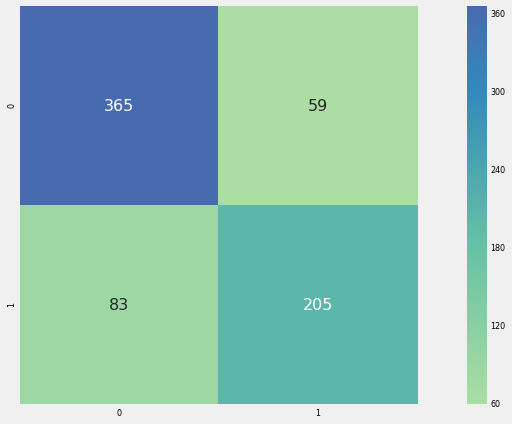

In [71]:
plt.figure(figsize=(14,6))
hm = sns.heatmap(cf,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='d',
                 annot_kws={'size': 16},
                 cmap = cmap)
plt.tight_layout()
plt.show()

By definition a confusion matrix C is such that C(i, j) is equal to the number of observations known to be in group i but predicted to be in group j. That is, rows correspond to classes, columns to predictions. So, we have here

In [52]:
print('{0:4d} true positives'.format(cf[0,0]))
print('{0:4d} false negatives'.format(cf[0,1]))
print('{0:4d} false positives'.format(cf[1,0]))
print('{0:4d} true negatives'.format(cf[1,1]))

 365 true positives
  59 false negatives
  83 false positives
 205 true negatives


*Precision* is defined as the ratio of elements predicted as positive which are indeed positive: P=TP/(TP+FP). In this case, the ratio of survived passenger correctly classified wrt the total number of passengers classified as survived

*Recall* is defined as the ratio of positive elements which are predicted as positive: P=TP/(TP+FN). In this case, the ratio of survived passenger correctly classified wrt the total number of survived passengers

*Accuracy* is defined as the ratio of correctly classified elements wrt to the overal number of elements

In [53]:
print('Precision = {0:5.4f}'.format(mt.precision_score(t,y)))
print('Recall = {0:5.4f}'.format(mt.recall_score(t,y)))
print('Accuracy = {0:5.4f}'.format(mt.accuracy_score(t,y)))

Precision = 0.7765
Recall = 0.7118
Accuracy = 0.8006


The model also returns measures of the confidence of passenger predictions. 

*class probabilities*: the estimated probability that a passenger is survived  
*confidence score*: the (signed) distance of the point corresponding to the passenger from the separating hyperplane

In [54]:
y_prob = clf.predict_proba(X)
conf_score = clf.decision_function(X)

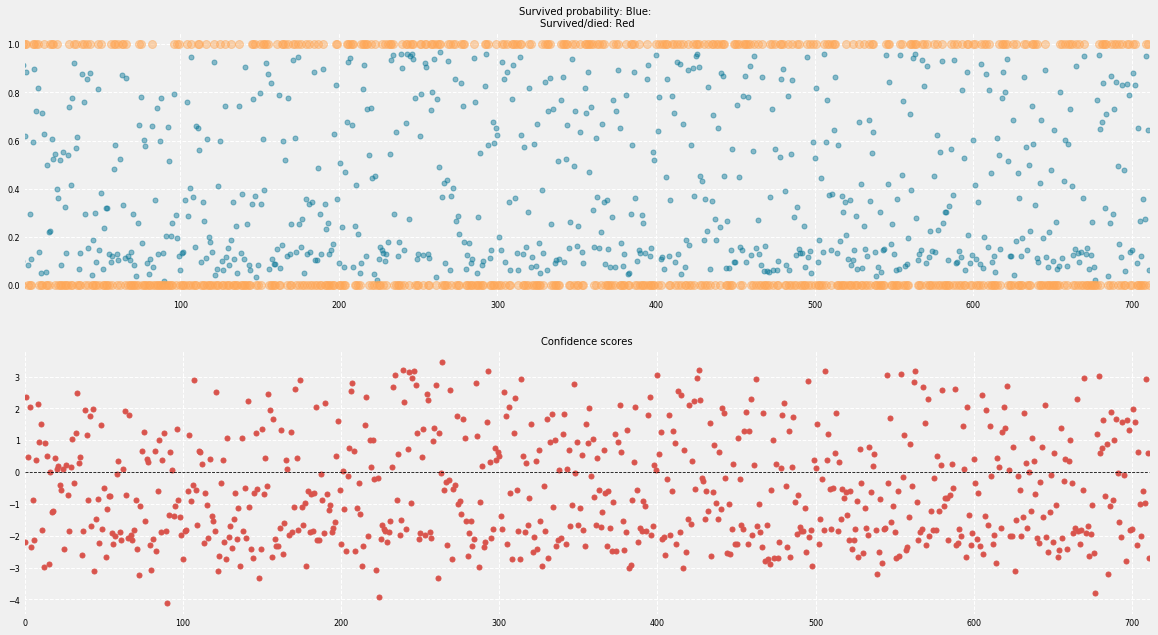

In [55]:
# Plot Predictions Vs Actual
y_prob = clf.predict_proba(X)
plt.figure(figsize=(18,10));
plt.subplot(211)
# generate predictions from our fitted model
plt.plot(range(y_prob.shape[0]), y_prob[:,1], color=colors[1], ms = 5, marker='o', linestyle=' ', alpha=.45);
plt.plot(range(y_prob.shape[0]), t, color=colors[0], marker='o', linestyle=' ', alpha=.45);
plt.grid(color='white', linestyle='dashed')
plt.xlim(1,y_prob.shape[0])
plt.title('Survived probability: Blue: \nSurvived/died: Red');


l = np.zeros(len(clf.decision_function(X)))
ax3 = plt.subplot(212)
plt.plot(conf_score, marker='o', linestyle=' ', ms = 5, color=colors[2])
plt.plot(l, color='black', linestyle='dashed', linewidth=.8)
plt.grid(color='white', linestyle='dashed')
ax3.set_xlim(-1, len(conf_score))
plt.title('Confidence scores');

A ROC (Receiver Operating Characteristic) curve represents, for any value of the threshold applied to the probabilities for classification, the ratio of positive elements correctly classified (as positive) and the ratio of negative elements incorrectly classified (as positive).

The ideal point is (0,1): no negative elements misclassified, all positive elements well classified.

In [56]:
fpr, tpr, thresholds = roc_curve(np.array(t), y_prob[:,1], pos_label=1)

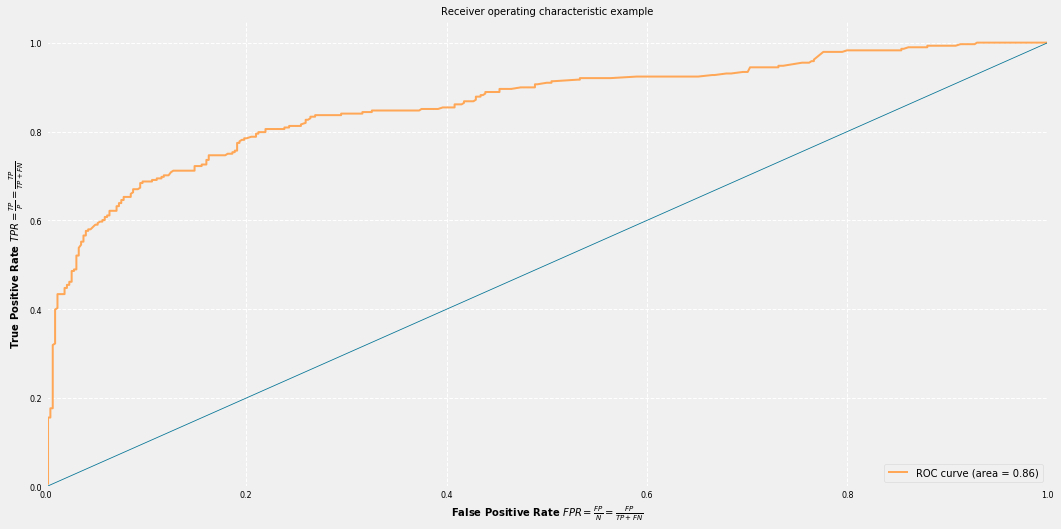

In [58]:
plt.figure(figsize=(16,8))
plt.plot(fpr, tpr, color=colors[0],label='ROC curve (area = %0.2f)' %  auc(fpr, tpr))
plt.plot([0, 1], [0, 1],color=colors[1], linewidth=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel(r'True Positive Rate $TPR=\frac{TP}{P}=\frac{TP}{TP+FN}$')
plt.xlabel(r'False Positive Rate $FPR=\frac{FP}{N}=\frac{FP}{TP+FN}$')
plt.title('Receiver operating characteristic example')
plt.grid(color='white', linestyle='dashed')
plt.legend(loc="lower right")
plt.show()

The Area under curve (AUC) provides a measure of the quality of the classifier.

In [59]:
print('AUC = {0:0.4f}'.format(auc(fpr, tpr)))

AUC = 0.8603


###  Now Let us Use our Model to predict the test set values
###  Split the dataset into training and test sets

In [60]:
X_train, X_test, t_train, t_test = model_selection.train_test_split(X, t, test_size=0.4)

Train the classifier on the training set

In [62]:
clf = clf.fit(X_train, t_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Perform predictions on both train and test data

In [63]:
y_train = clf.predict(X_train)
y_test = clf.predict(X_test)

Compute measures in both cases

In [64]:
cf_train = mt.confusion_matrix(t_train, y_train)
print('Confusion matrix')
print(cf_train)

print ('Precision = {0:5.4f}'.format(mt.precision_score(t_train,y_train)))
print ('Recall = {0:5.4f}'.format(mt.recall_score(t_train,y_train)))
print ('Accuracy = {0:5.4f}'.format(mt.accuracy_score(t_train,y_train)))

Confusion matrix
[[231  31]
 [ 56 109]]
Precision = 0.7786
Recall = 0.6606
Accuracy = 0.7963


NameError: name 'sns' is not defined

<Figure size 1008x432 with 0 Axes>

In [65]:
cf_test = mt.confusion_matrix(t_test, y_test)
print('Confusion matrix')
print(cf_test)

print ('Precision = {0:5.4f}'.format(mt.precision_score(t_test, y_test)))
print ('Recall = {0:5.4f}'.format(mt.recall_score(t_test, y_test)))
print ('Accuracy = {0:5.4f}'.format(mt.accuracy_score(t_test, y_test)))

Confusion matrix
[[131  31]
 [ 34  89]]
Precision = 0.7417
Recall = 0.7236
Accuracy = 0.7719


### Check performance with different regularization parameters

In [40]:
best_coeff, best_meas = 0,0
for i in np.logspace(-3,3,20):
    clf.set_params(penalty='l2', C=i)
    clf.fit(X_train, t_train)
    y_test = clf.predict(X_test)
    acc = mt.accuracy_score(t_test,y_test)
    if acc > best_meas:
        best_meas = acc
        best_coeff = i
    print ('C = {0:5.3f}; Accuracy = {1:0.4f}'.format(i, acc))
print("Best accuracy = {0:0.4f} for i = {0:5.3f}".format(best_meas, best_coeff))

C = 0.001; Accuracy = 0.6070
C = 0.002; Accuracy = 0.6105
C = 0.004; Accuracy = 0.6316
C = 0.009; Accuracy = 0.7123
C = 0.018; Accuracy = 0.7825
C = 0.038; Accuracy = 0.7895
C = 0.078; Accuracy = 0.7965
C = 0.162; Accuracy = 0.8105
C = 0.336; Accuracy = 0.8140
C = 0.695; Accuracy = 0.8140
C = 1.438; Accuracy = 0.8070
C = 2.976; Accuracy = 0.8105
C = 6.158; Accuracy = 0.8140
C = 12.743; Accuracy = 0.8140
C = 26.367; Accuracy = 0.8140
C = 54.556; Accuracy = 0.8140
C = 112.884; Accuracy = 0.8140
C = 233.572; Accuracy = 0.8140
C = 483.293; Accuracy = 0.8140
C = 1000.000; Accuracy = 0.8140
Best accuracy = 0.8140 for i = 0.814


In [41]:
best_coeff, best_meas = 0,0
for i in np.logspace(-3,3,20):
    clf.set_params(penalty='l1', C=i)
    clf.fit(X_train, t_train)
    y_test = clf.predict(X_test)
    acc = mt.accuracy_score(t_test,y_test)
    if acc > best_meas:
        best_meas = acc
        best_coeff = i
    print ('C = {0:5.3f}; Accuracy = {1:0.4f}'.format(i, acc))
print("Best accuracy = {0:0.4f} for i = {0:5.3f}".format(best_meas, best_coeff))

C = 0.001; Accuracy = 0.6070
C = 0.002; Accuracy = 0.6070
C = 0.004; Accuracy = 0.6070
C = 0.009; Accuracy = 0.6070
C = 0.018; Accuracy = 0.6070
C = 0.038; Accuracy = 0.8035
C = 0.078; Accuracy = 0.7930
C = 0.162; Accuracy = 0.8070
C = 0.336; Accuracy = 0.8140
C = 0.695; Accuracy = 0.8105
C = 1.438; Accuracy = 0.8140
C = 2.976; Accuracy = 0.8175
C = 6.158; Accuracy = 0.8175
C = 12.743; Accuracy = 0.8140
C = 26.367; Accuracy = 0.8140
C = 54.556; Accuracy = 0.8140
C = 112.884; Accuracy = 0.8140
C = 233.572; Accuracy = 0.8140
C = 483.293; Accuracy = 0.8140
C = 1000.000; Accuracy = 0.8140
Best accuracy = 0.8175 for i = 0.818


In [42]:
best_coeff, best_meas = 0,0
for i in np.linspace(1.3,1.5,20):
    clf.set_params(penalty='l1', C=i)
    clf.fit(X_train, t_train)
    y_test = clf.predict(X_test)
    acc = mt.accuracy_score(t_test,y_test)
    if acc > best_meas:
        best_meas = acc
        best_coeff = i
    print ('C = {0:5.3f}; Accuracy = {1:0.4f}'.format(i, acc))
print("Best accuracy = {0:0.4f} for i = {0:5.3f}".format(best_meas, best_coeff))

C = 1.300; Accuracy = 0.8140
C = 1.311; Accuracy = 0.8140
C = 1.321; Accuracy = 0.8140
C = 1.332; Accuracy = 0.8140
C = 1.342; Accuracy = 0.8140
C = 1.353; Accuracy = 0.8140
C = 1.363; Accuracy = 0.8140
C = 1.374; Accuracy = 0.8140
C = 1.384; Accuracy = 0.8140
C = 1.395; Accuracy = 0.8140
C = 1.405; Accuracy = 0.8140
C = 1.416; Accuracy = 0.8140
C = 1.426; Accuracy = 0.8140
C = 1.437; Accuracy = 0.8140
C = 1.447; Accuracy = 0.8140
C = 1.458; Accuracy = 0.8140
C = 1.468; Accuracy = 0.8140
C = 1.479; Accuracy = 0.8140
C = 1.489; Accuracy = 0.8140
C = 1.500; Accuracy = 0.8140
Best accuracy = 0.8140 for i = 0.814


Check performances of the classifier with best accuracy

In [43]:
clf.set_params(penalty='l1', C=best_coeff)
clf.fit(X_train, t_train)
y_test = clf.predict(X_test)
cf_test = mt.confusion_matrix(t_test, y_test)
print cf_test
print ('Precision = {0:0.4f}'.format(mt.precision_score(t_test, y_test)))
print ('Recall = {0:0.4f}'.format(mt.recall_score(t_test, y_test)))
print ('Accuracy = {0:0.4f}'.format(mt.accuracy_score(t_test, y_test)))

[[152  21]
 [ 32  80]]
Precision = 0.7921
Recall = 0.7143
Accuracy = 0.8140


Let's try with a different, more synthetic, measure. F1 measure is defined as $\frac{2(precision\times  recall)}{precision+recall}$

In [44]:
best_coeff, best_meas = 0,0
for i in np.logspace(-3,3,20):
    clf.set_params(penalty='l1', C=i)
    clf.fit(X_train, t_train)
    y_test = clf.predict(X_test)
    f1 = mt.f1_score(t_test,y_test)
    if f1 > best_meas:
        best_meas = f1
        best_coeff = i
    print ('C = {0:5.3f}; F1 = {1:0.4f}'.format(i, f1))
print("Best F1 = {0:0.4f} for i = {1:5.3f}".format(best_meas, best_coeff))

C = 0.001; F1 = 0.0000
C = 0.002; F1 = 0.0000
C = 0.004; F1 = 0.0000
C = 0.009; F1 = 0.0000
C = 0.018; F1 = 0.0000
C = 0.038; F1 = 0.7255
C = 0.078; F1 = 0.7177
C = 0.162; F1 = 0.7343
C = 0.336; F1 = 0.7464
C = 0.695; F1 = 0.7429
C = 1.438; F1 = 0.7512
C = 2.976; F1 = 0.7570
C = 6.158; F1 = 0.7512
C = 12.743; F1 = 0.7512
C = 26.367; F1 = 0.7512
C = 54.556; F1 = 0.7512
C = 112.884; F1 = 0.7512
C = 233.572; F1 = 0.7512
C = 483.293; F1 = 0.7512
C = 1000.000; F1 = 0.7512
Best F1 = 0.7570 for i = 2.976


In [45]:
clf.set_params(penalty='l1', C=best_coeff)
clf.fit(X_train, t_train)
y_test = clf.predict(X_test)
cf_test = mt.confusion_matrix(t_test, y_test)
print cf_test
print ('Precision = {0:0.4f}'.format(mt.precision_score(t_test, y_test)))
print ('Recall = {0:0.4f}'.format(mt.recall_score(t_test, y_test)))
print ('Accuracy = {0:0.4f}'.format(mt.accuracy_score(t_test, y_test)))

[[152  21]
 [ 31  81]]
Precision = 0.7941
Recall = 0.7232
Accuracy = 0.8175


In [46]:
best_coeff, best_meas = 0,0
for i in np.logspace(-3,3,20):
    clf.set_params(penalty='l2', C=i)
    clf.fit(X_train, t_train)
    y_test = clf.predict(X_test)
    f1 = mt.f1_score(t_test,y_test)
    if f1 > best_meas:
        best_meas = f1
        best_coeff = i
    print ('C = {0:5.3f}; F1 = {1:0.4f}'.format(i, f1))
print("Best F1 = {0:0.4f} for i = {1:5.3f}".format(best_meas, best_coeff))

C = 0.001; F1 = 0.0000
C = 0.002; F1 = 0.0177
C = 0.004; F1 = 0.1322
C = 0.009; F1 = 0.4744
C = 0.018; F1 = 0.6702
C = 0.038; F1 = 0.7000
C = 0.078; F1 = 0.7157
C = 0.162; F1 = 0.7379
C = 0.336; F1 = 0.7440
C = 0.695; F1 = 0.7464
C = 1.438; F1 = 0.7368
C = 2.976; F1 = 0.7453
C = 6.158; F1 = 0.7512
C = 12.743; F1 = 0.7512
C = 26.367; F1 = 0.7512
C = 54.556; F1 = 0.7512
C = 112.884; F1 = 0.7512
C = 233.572; F1 = 0.7512
C = 483.293; F1 = 0.7512
C = 1000.000; F1 = 0.7512
Best F1 = 0.7512 for i = 6.158


In [47]:
clf.set_params(penalty='l2', C=best_coeff)
clf.fit(X_train, t_train)
y_test = clf.predict(X_test)
cf_test = mt.confusion_matrix(t_test, y_test)
print cf_test

print ('Precision = {0:0.4f}'.format(mt.precision_score(t_test, y_test)))
print ('Recall = {0:0.4f}'.format(mt.recall_score(t_test, y_test)))
print ('Accuracy = {0:0.4f}'.format(mt.accuracy_score(t_test, y_test)))

[[152  21]
 [ 32  80]]
Precision = 0.7921
Recall = 0.7143
Accuracy = 0.8140


## Try different classifiers

### Support Vector Machine (SVM)

In [48]:
clf = svm.SVC()
clf.fit(X_train, t_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [49]:
y_test = clf.predict(X_test)

In [50]:
cf_test = mt.confusion_matrix(t_test, y_test)
print('Confusion matrix')
print(cf_test)

print ('Precision = {0:0.4f}'.format(mt.precision_score(t_test, y_test)))
print ('Recall = {0:0.4f}'.format(mt.recall_score(t_test, y_test)))
print ('Accuracy = {0:0.4f}'.format(mt.accuracy_score(t_test, y_test)))

Confusion matrix
[[160  13]
 [ 46  66]]
Precision = 0.8354
Recall = 0.5893
Accuracy = 0.7930


In [51]:
clf.set_params(kernel='linear')
clf.fit(X_train, t_train)
y_test = clf.predict(X_test)
cf_test = mt.confusion_matrix(t_test, y_test)
print cf_test
print ('Precision = {0:0.4f}'.format(mt.precision_score(t_test, y_test)))
print ('Recall = {0:0.4f}'.format(mt.recall_score(t_test, y_test)))
print ('Accuracy = {0:0.4f}'.format(mt.accuracy_score(t_test, y_test)))

[[151  22]
 [ 37  75]]
Precision = 0.7732
Recall = 0.6696
Accuracy = 0.7930


In [52]:
clf.set_params(kernel='poly', degree=2)
clf.fit(X_train, t_train)
y_test = clf.predict(X_test)
cf_test = mt.confusion_matrix(t_test, y_test)
print cf_test
print ('Precision = {0:0.4f}'.format(mt.precision_score(t_test, y_test)))
print ('Recall = {0:0.4f}'.format(mt.recall_score(t_test, y_test)))
print ('Accuracy = {0:0.4f}'.format(mt.accuracy_score(t_test, y_test)))

[[156  17]
 [ 33  79]]
Precision = 0.8229
Recall = 0.7054
Accuracy = 0.8246


## Random Forests

In [53]:
clf = ensemble.RandomForestClassifier()
clf.fit(X_train, t_train)
y_test = clf.predict(X_test)
cf_test = mt.confusion_matrix(t_test, y_test)
print('Confusion matrix')
print(cf_test)
print ('Precision = {0:0.4f}'.format(mt.precision_score(t_test, y_test)))
print ('Recall = {0:0.4f}'.format(mt.recall_score(t_test, y_test)))
print ('Accuracy = {0:0.4f}'.format(mt.accuracy_score(t_test, y_test)))
print ('F1 = %0.4f' % mt.f1_score(t_test, y_test))

Confusion matrix
[[149  24]
 [ 33  79]]
Precision = 0.7670
Recall = 0.7054
Accuracy = 0.8000
F1 = 0.7349


In [54]:
best_coeff, best_meas = 0,0
n = []
f = []
for i in range(10,50,2):
    clf = ensemble.RandomForestClassifier(n_estimators=i)
    clf.fit(X_train, t_train)
    y_test = clf.predict(X_test)
    f1 = mt.f1_score(t_test,y_test)
    n.append(i)
    f.append(f1)
    if f1 > best_meas:
        best_meas = f1
        best_coeff = i
    print ('n = {0:3d}; F1 = {1:0.4f}'.format(i, f1))
print("Best F1 = {0:0.4f} for n = {1:3d}".format(best_meas, best_coeff))

n =  10; F1 = 0.7547
n =  12; F1 = 0.7170
n =  14; F1 = 0.7240
n =  16; F1 = 0.7512
n =  18; F1 = 0.7136
n =  20; F1 = 0.7215
n =  22; F1 = 0.7368
n =  24; F1 = 0.7170
n =  26; F1 = 0.7149
n =  28; F1 = 0.7383
n =  30; F1 = 0.7512
n =  32; F1 = 0.7453
n =  34; F1 = 0.7678
n =  36; F1 = 0.7189
n =  38; F1 = 0.7256
n =  40; F1 = 0.7465
n =  42; F1 = 0.7196
n =  44; F1 = 0.7383
n =  46; F1 = 0.7256
n =  48; F1 = 0.7281
Best F1 = 0.7678 for n =  34


In [55]:
zip(n,f)

[(10, 0.7547169811320756),
 (12, 0.7169811320754718),
 (14, 0.7239819004524886),
 (16, 0.7512195121951218),
 (18, 0.7136150234741784),
 (20, 0.7214611872146119),
 (22, 0.7368421052631579),
 (24, 0.7169811320754718),
 (26, 0.7149321266968326),
 (28, 0.7383177570093459),
 (30, 0.7511737089201879),
 (32, 0.7452830188679247),
 (34, 0.7677725118483413),
 (36, 0.7188940092165899),
 (38, 0.7255813953488373),
 (40, 0.7465437788018433),
 (42, 0.7196261682242991),
 (44, 0.7383177570093459),
 (46, 0.7255813953488373),
 (48, 0.7281105990783412)]

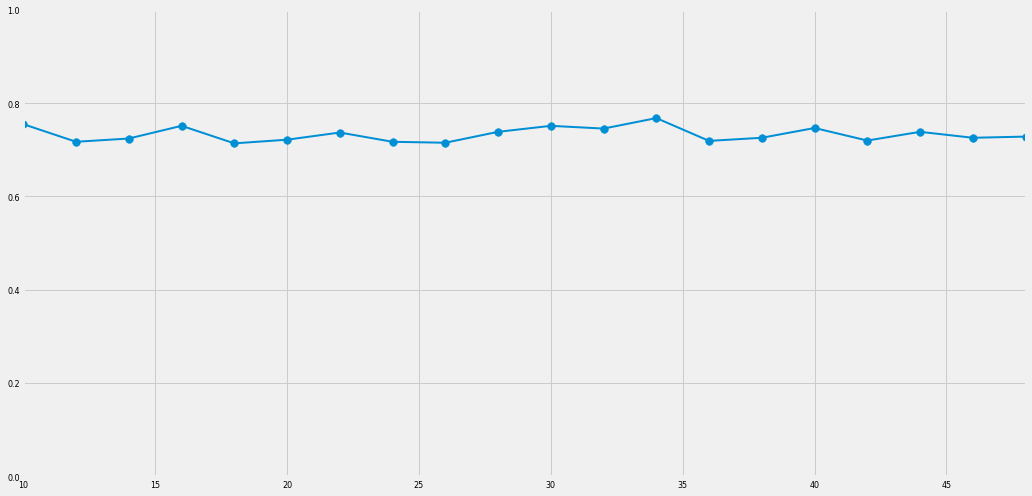

In [59]:
plt.figure(figsize=(16,8))
plt.plot(n, f, color=colors[0])
plt.scatter(n,f, color=colors[0], s=60)
plt.xlim([n[0], n[-1]])
plt.ylim([0.0, 1])
plt.show()

In [60]:
clf.set_params(n_estimators=best_coeff)
clf.fit(X_train, t_train)
y_test = clf.predict(X_test)
cf_test = mt.confusion_matrix(t_test, y_test)
print cf_test
print ('Precision = {0:0.4f}'.format(mt.precision_score(t_test, y_test)))
print ('Recall = {0:0.4f}'.format(mt.recall_score(t_test, y_test)))
print ('Accuracy = {0:0.4f}'.format(mt.accuracy_score(t_test, y_test)))

[[147  26]
 [ 33  79]]
Precision = 0.7524
Recall = 0.7054
Accuracy = 0.7930


## Using cross validation

k-fold cross validation: dataset partitioned into k subsets. 
k phases, at phase i use the i-th subset for testing, the rest of data for training. 
Average performances on all phases.

In [61]:
X = preprocessing.scale(X)

In [62]:
scores = cross_val_score(clf, X, t, scoring='accuracy',cv=5)

In [63]:
np.mean(scores)

0.7754820047597992

In [64]:
best_coeff, best_meas, reg = 0,0, 'l1'
clf_l1 = linear_model.LogisticRegression()
clf_l2 = linear_model.LogisticRegression()
for i in np.logspace(-1,5,20):
    clf_l1.set_params(penalty='l1', C=i)
    clf_l2.set_params(penalty='l2', C=i)
    m1 = model_selection.cross_val_score(clf_l1, X, t, scoring='accuracy',cv=5).mean()
    m2 = model_selection.cross_val_score(clf_l2, X, t, scoring='accuracy',cv=5).mean()
    if m1 > best_meas:
        best_meas = m1
        best_coeff = i
        reg = 'l1'
    if m2 > best_meas:
        best_meas = m2
        best_coeff = i
        reg = 'l2'
    print("C= {0:3.0f} -  l1: {1:0.4f}, l2: {2:0.4f}".format(i, m1, m2))
print("Best accuracy = {0:0.4f} for C = {1:3.0f} and {2:s} regularization".format(best_meas, best_coeff, reg))

C=   0 -  l1: 0.7795, l2: 0.7739
C=   0 -  l1: 0.7739, l2: 0.7782
C=   0 -  l1: 0.7782, l2: 0.7838
C=   1 -  l1: 0.7838, l2: 0.7852
C=   2 -  l1: 0.7866, l2: 0.7852
C=   4 -  l1: 0.7866, l2: 0.7880
C=   8 -  l1: 0.7880, l2: 0.7880
C=  16 -  l1: 0.7880, l2: 0.7880
C=  34 -  l1: 0.7880, l2: 0.7880
C=  70 -  l1: 0.7880, l2: 0.7880
C= 144 -  l1: 0.7880, l2: 0.7880
C= 298 -  l1: 0.7880, l2: 0.7880
C= 616 -  l1: 0.7880, l2: 0.7880
C= 1274 -  l1: 0.7880, l2: 0.7880
C= 2637 -  l1: 0.7880, l2: 0.7880
C= 5456 -  l1: 0.7880, l2: 0.7880
C= 11288 -  l1: 0.7880, l2: 0.7880
C= 23357 -  l1: 0.7880, l2: 0.7880
C= 48329 -  l1: 0.7880, l2: 0.7880
C= 100000 -  l1: 0.7880, l2: 0.7880
Best accuracy = 0.7880 for C =   4 and l2 regularization


In [65]:
clf = linear_model.LogisticRegression(penalty=reg, C=best_coeff)
acc = model_selection.cross_val_score(clf, X, t, scoring='accuracy',cv=5).mean()
print("Accuracy: {0:0.4f}".format(acc))

Accuracy: 0.7880


In [66]:
prec = model_selection.cross_val_score(clf, X, t, scoring='precision',cv=5).mean()
print("Precision: {0:0.4f}".format(prec))

Precision: 0.7638


In [67]:
rec = model_selection.cross_val_score(clf, X, t, scoring='recall',cv=5).mean()
print("Recall: {0:0.4f}".format(rec))

Recall: 0.6944


In [68]:
best_coeff1, best_coeff2, best_meas = 0,0,0
clf = svm.SVC(kernel='rbf')
for c in np.linspace(0.5,1.5,10):
    for gamma in np.linspace(0.015,0.025,10):
        clf.set_params(gamma=gamma, C=c)
        m = model_selection.cross_val_score(clf, X, t, scoring='accuracy',cv=5).mean()
        if m > best_meas:
            best_coeff1 = c
            best_coeff2 = gamma
            best_meas = m
        print("gamma= {0:5.4f}, C={1:1.4f}: {2:0.4f}".format(gamma, c, m))
print("Best accuracy = {0:0.4f} for C = {1:1.4f}, gamma = {2:5.4f}".format(best_meas, best_coeff1, best_coeff2))

gamma= 0.0150, C=0.5000: 0.7795
gamma= 0.0161, C=0.5000: 0.7809
gamma= 0.0172, C=0.5000: 0.7739
gamma= 0.0183, C=0.5000: 0.7739
gamma= 0.0194, C=0.5000: 0.7739
gamma= 0.0206, C=0.5000: 0.7767
gamma= 0.0217, C=0.5000: 0.7781
gamma= 0.0228, C=0.5000: 0.7781
gamma= 0.0239, C=0.5000: 0.7781
gamma= 0.0250, C=0.5000: 0.7781
gamma= 0.0150, C=0.6111: 0.7795
gamma= 0.0161, C=0.6111: 0.7739
gamma= 0.0172, C=0.6111: 0.7739
gamma= 0.0183, C=0.6111: 0.7753
gamma= 0.0194, C=0.6111: 0.7753
gamma= 0.0206, C=0.6111: 0.7767
gamma= 0.0217, C=0.6111: 0.7781
gamma= 0.0228, C=0.6111: 0.7781
gamma= 0.0239, C=0.6111: 0.7781
gamma= 0.0250, C=0.6111: 0.7781
gamma= 0.0150, C=0.7222: 0.7739
gamma= 0.0161, C=0.7222: 0.7753
gamma= 0.0172, C=0.7222: 0.7753
gamma= 0.0183, C=0.7222: 0.7753
gamma= 0.0194, C=0.7222: 0.7767
gamma= 0.0206, C=0.7222: 0.7767
gamma= 0.0217, C=0.7222: 0.7781
gamma= 0.0228, C=0.7222: 0.7781
gamma= 0.0239, C=0.7222: 0.7781
gamma= 0.0250, C=0.7222: 0.7781
gamma= 0.0150, C=0.8333: 0.7753
gamma= 0

In [69]:
clf = svm.SVC(kernel='rbf',gamma=best_coeff2, C=best_coeff1)
m = model_selection.cross_val_score(clf, X, t, scoring='accuracy',cv=5).mean()
print("Accuracy: {0:0.4f}".format(m))

Accuracy: 0.7893


In [70]:
m = model_selection.cross_val_score(clf, X, t, scoring='precision',cv=5).mean()
print("Precision: {0:0.4f}".format(m))

Precision: 0.7825


In [71]:
m = model_selection.cross_val_score(clf, X, t, scoring='recall',cv=5).mean()
print("Recall: {0:0.4f}".format(m))

Recall: 0.6629


In [72]:
best_coeff1, best_coeff2, best_meas = 0,0,0
clf = svm.SVC(kernel='poly', degree=2)
for c in np.linspace(1.5,1.53,5):
    for gamma in np.linspace(0.018,0.5,5):
        clf.set_params(gamma=gamma, C=c)
        m = model_selection.cross_val_score(clf, X, t, scoring='accuracy',cv=5).mean()
        if m > best_meas:
            best_coeff1 = c
            best_coeff2 = gamma
            best_meas = m
        print("gamma= %5.4f, C=%1.4f: %0.4f" % (gamma, c, m))
print("Best accuracy = %0.4f for C = %1.4f, gamma = %5.4f" % (best_meas, best_coeff1, best_coeff2))

gamma= 0.0180, C=1.5000: 0.6615
gamma= 0.1385, C=1.5000: 0.7908
gamma= 0.2590, C=1.5000: 0.7894
gamma= 0.3795, C=1.5000: 0.7908
gamma= 0.5000, C=1.5000: 0.7894
gamma= 0.0180, C=1.5075: 0.6615
gamma= 0.1385, C=1.5075: 0.7908
gamma= 0.2590, C=1.5075: 0.7894
gamma= 0.3795, C=1.5075: 0.7908
gamma= 0.5000, C=1.5075: 0.7894
gamma= 0.0180, C=1.5150: 0.6615
gamma= 0.1385, C=1.5150: 0.7908
gamma= 0.2590, C=1.5150: 0.7894
gamma= 0.3795, C=1.5150: 0.7908
gamma= 0.5000, C=1.5150: 0.7894
gamma= 0.0180, C=1.5225: 0.6615
gamma= 0.1385, C=1.5225: 0.7908
gamma= 0.2590, C=1.5225: 0.7894
gamma= 0.3795, C=1.5225: 0.7908
gamma= 0.5000, C=1.5225: 0.7894
gamma= 0.0180, C=1.5300: 0.6615
gamma= 0.1385, C=1.5300: 0.7908
gamma= 0.2590, C=1.5300: 0.7894
gamma= 0.3795, C=1.5300: 0.7908
gamma= 0.5000, C=1.5300: 0.7894
Best accuracy = 0.7908 for C = 1.5000, gamma = 0.3795


In [73]:
clf = svm.SVC(kernel='poly', degree=2, gamma=best_coeff2, C=best_coeff1)
m = model_selection.cross_val_score(clf, X, t, scoring='accuracy',cv=5).mean()
print("Accuracy: %0.4f" % m)

Accuracy: 0.7908


In [74]:
m = model_selection.cross_val_score(clf, X, t, scoring='precision',cv=5).mean()
print("Precision: %0.4f" % m)

Precision: 0.7821


In [75]:
m = model_selection.cross_val_score(clf, X, t, scoring='recall',cv=5).mean()
print("Recall: %0.4f" % m)

Recall: 0.6699


In [76]:
best_coeff, best_meas = 0,0
clf = svm.SVC(kernel='linear')
for c in np.linspace(0.007,0.008,20):
    clf.set_params(C=c)
    m = model_selection.cross_val_score(clf, X, t, scoring='accuracy',cv=5).mean()
    if m > best_meas:
            best_coeff = c
            best_meas = m
    print("C=%1.4f: %0.4f" % (c,m))
print("Best accuracy = %0.4f for C = %1.4f" % (best_meas, best_coeff))

C=0.0070: 0.7795
C=0.0071: 0.7795
C=0.0071: 0.7795
C=0.0072: 0.7795
C=0.0072: 0.7795
C=0.0073: 0.7795
C=0.0073: 0.7795
C=0.0074: 0.7795
C=0.0074: 0.7795
C=0.0075: 0.7795
C=0.0075: 0.7795
C=0.0076: 0.7795
C=0.0076: 0.7795
C=0.0077: 0.7795
C=0.0077: 0.7795
C=0.0078: 0.7795
C=0.0078: 0.7795
C=0.0079: 0.7795
C=0.0079: 0.7795
C=0.0080: 0.7795
Best accuracy = 0.7795 for C = 0.0070


In [77]:
clf = svm.SVC(kernel='linear', C=best_coeff)
m = model_selection.cross_val_score(clf, X, t, scoring='accuracy',cv=5).mean()
print("Accuracy: %0.4f" % m)
m = model_selection.cross_val_score(clf, X, t, scoring='precision',cv=5).mean()
print("Precision: %0.4f" % m)
m = model_selection.cross_val_score(clf, X, t, scoring='recall',cv=5).mean()
print("Recall: %0.4f" % m)

Accuracy: 0.7795
Precision: 0.7518
Recall: 0.6767


In [78]:
best_coeff1, best_coeff2, best_meas = 0,0,0
clf = svm.SVC(kernel='poly', degree=3)
for c in np.linspace(0.1,0.2,2):
    for gamma in np.logspace(0.1,0.2,2):
        clf.set_params(gamma=gamma, C=c)
        m = model_selection.cross_val_score(clf, X, t, scoring='accuracy',cv=5).mean()
        if m > best_meas:
            best_coeff1 = c
            best_coeff2 = gamma
            best_meas = m
        print("gamma= %5.4f, C=%1.4f: %0.4f" % (gamma, c, m))
print("Best accuracy = %0.4f for C = %1.4f, gamma = %5.4f" % (best_meas, best_coeff1, best_coeff2))

gamma= 1.2589, C=0.1000: 0.7641
gamma= 1.5849, C=0.1000: 0.7613
gamma= 1.2589, C=0.2000: 0.7613
gamma= 1.5849, C=0.2000: 0.7656
Best accuracy = 0.7656 for C = 0.2000, gamma = 1.5849


In [79]:
best_coeff, best_meas = 0,0
clf = ensemble.BaggingClassifier(linear_model.LogisticRegression(),max_samples=0.5, max_features=0.5)
for i in range(10,80,5):
    clf.set_params(n_estimators=i)
    m = model_selection.cross_val_score(clf, X, t, scoring='accuracy',cv=5).mean()
    if m > best_meas:
        best_coeff = i
        best_meas = m
    print("n= %i: %0.4f" % (i, m))
print("Best accuracy = %0.4f for n = %i" % (best_meas, best_coeff))

n= 10: 0.7781
n= 15: 0.7753
n= 20: 0.7655
n= 25: 0.7711
n= 30: 0.7767
n= 35: 0.7781
n= 40: 0.7627
n= 45: 0.7711
n= 50: 0.7669
n= 55: 0.7725
n= 60: 0.7697
n= 65: 0.7725
n= 70: 0.7726
n= 75: 0.7669
Best accuracy = 0.7781 for n = 35


In [80]:
clf = ensemble.BaggingClassifier(linear_model.LogisticRegression(),n_estimators=best_coeff, max_samples=0.5, max_features=0.5)
m = model_selection.cross_val_score(clf, X, t, scoring='accuracy',cv=5).mean()
print("Accuracy: %0.4f" % m)
m = model_selection.cross_val_score(clf, X, t, scoring='precision',cv=5).mean()
print("Precision: %0.4f" % m)
m = model_selection.cross_val_score(clf, X, t, scoring='recall',cv=5).mean()
print("Recall: %0.4f" % m)

Accuracy: 0.7739
Precision: 0.7359
Recall: 0.6802


In [81]:
best_coeff, best_meas = 0,0
clf = ensemble.RandomForestClassifier(max_depth=5)
for i in range(75,85,1):
    clf.set_params(n_estimators=i)
    m = model_selection.cross_val_score(clf, X, t, scoring='accuracy',cv=5).mean()
    if m > best_meas:
        best_coeff = i
        best_meas = m
    print("n= %i: %0.4f" % (i, m))
print("Best accuracy = %0.4f for n = %i" % (best_meas, best_coeff))

n= 75: 0.8091
n= 76: 0.8049
n= 77: 0.8105
n= 78: 0.8120
n= 79: 0.8007
n= 80: 0.8035
n= 81: 0.8049
n= 82: 0.8119
n= 83: 0.8063
n= 84: 0.8050
Best accuracy = 0.8120 for n = 78


In [82]:
clf = ensemble.RandomForestClassifier(n_estimators=best_coeff, max_depth=5)
m = model_selection.cross_val_score(clf, X, t, scoring='accuracy',cv=5).mean()
print("Accuracy: %0.4f" % m)
m = model_selection.cross_val_score(clf, X, t, scoring='precision',cv=5).mean()
print("Precision: %0.4f" % m)
m = model_selection.cross_val_score(clf, X, t, scoring='recall',cv=5).mean()
print("Recall: %0.4f" % m)

Accuracy: 0.8134
Precision: 0.8259
Recall: 0.6701
